# Exercises 5-8

Exercises on stochastic matrices, detailed balance and the Ising model. These are more involved than the previous 4 exercises.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Exercise 5: Stochastic matrices
A $N\times N$ matrix is called stochastic if 
a) all elements are non-negative: $\forall i, j \in {1,..., N}: P_{ij}\geq 0$ and 
b) the sum of all columns is equal to 1: $\forall i\in {1,..., N}: \sum_{i=1}^{N}P_{ij} = 1$.

Given a system with N states, the stochastic matrix generates the dynamics of the system. The element $P_{ij}$ is the transition rate that the system does in a time interval $\Delta t$ from the state $j$ to the state $i$. One also uses the notation $P_{ij} = p(j \to i)$.

Therefore if $w(t)$ is a vector, whose elements $w_i(t)$ are probabilities of finding the system in a state $i$ at time $t$ then at time $t + \Delta t$, the probabilities are the elements of the vector obtained by multiplication with the matrix $P $:
$$
w(t + \Delta t) = P w(t)
$$
Note that a state of the system is described by a vector of non-negative entries
$w_i \geq 0$. We will call a non-negative vector a vector whose elements are all non-negative.

## Exercise 6: detailed balance

Exercise made on paper. Will immediately insert the solution in the final report.

## Exercise 7: Ising model, uniform sampling

We use $N\times N $ square lattice. The total energy for a certain spin configuration is given as 
$$
E(\{s_k\}) = -J\sum_{<ij>}s_i s_j
$$
where the sum extends over the four nearest neighbour spins. We assume $J>0$, this characterizes the strength of the interaction.
We will now construct a simple Monte Carlo algorithm that uniformly samples all configurations of the model, to show that this is very inefficient sampling. 

### Generating lattice configuration & boundary conditions

Most used boundary condition: the periodic boundary conditions. With $s(i,j)$ we indicate the spin at lattice site $(i,j)$. With periodic boundary conditions, these are given by 
- The spin above and below are: $s(\mod(i\pm 1+N, N),j)$
- The spin right and left are: $s(i, \mod(j\pm 1+N, N))$

However, computationally simpler boundary conditions: helical boundary conditions. We now label all spins as a vector $s(i)$ and fill up lattice from bottom left to top right as in example 14b. The $N\times N$ lattice is repeated in all directions, but shifted by one unit vertically. The consequences are 
- The spin above and below are $s(\mod(i\pm N+N^2, N^2))$.
- The spin left and right are $s(\mod(i\pm 1+N^2, N^2))$.

### Uniform sampling
We follow the next algorithm:
- Let $\omega$ be an empty vector
- Generate a random configuration of $N^2$ spins.
- Calculate the energy $E$ of the generated configuration, and add to the vector $\omega$.
- Go back to step 2.

In [ ]:
# Definition of functions

def energy(spin_configuration, J):
    '''
    Input should be a NxN matrix
    '''
    E = 0
    N = len(spin_configuration[0])
    for i in range(N-1):
        for j in range(N-1):
            E += -J*( spin_configuration[i][j]*spin_configuration[i+1][j]+ spin_configuration[i][j]*spin_configuration[i][j+1])
    for j in range(N-1):
        E +=-J * spin_configuration[N-1][j]*spin_configuration[N-1][j+1]
    for i in range(N-1):
        E +=-J * spin_configuration[i][N-1]*spin_configuration[i][N-1]
    return E

In [ ]:
# be careful with running this cell multiple times !
N = 10

lattice = np.empty((N, N))

for i in range(N):
    for j in range(N):
        spin = np.random.randint(0, 2, 1)
        if spin[0] == 0:
            lattice[i][j] += -1
        else: 
            lattice[i][j] += spin[0]
lattice

In [ ]:
J = 1
E = energy(lattice, J)
print('Energy = ', E)

In [ ]:
steps = int(1e3)
energies = np.zeros(steps)



### Function-based approach

Here we make use of functions to calculate the Ising model. If I have time I'll create a class with the following functionality:
- Can be initialized with some keywords related to boundary conditions, size, sampling method
- Has some built-in functions: energy variation, generate random sample, return plots concerning  

In [ ]:
def initialize_ising(N):
    """
    Initialize the NxN lattice with helical boundary conditions.

    Parameters:
    - N: int
        Size of the lattice (N x N).
    - seed: int, optional
        Random seed for reproducibility.

    Returns:
    - spins: np.ndarray
        1D array of length N^2 representing the spin configuration with values in {-1, 1}.
    """
    
    # Create random 1D array of length N^2
    spins = np.random.choice([-1, 1], size=N**2)
    return spins

In [ ]:
def get_neighbors(i, N, boundary='helical'):
    """
    Get the indices of neighbors for spin `i` in a 1D representation of the NxN Ising lattice
    with helical boundary conditions.

    Parameters:
    - i: int
        Index of the current spin (0 <= i < N^2).
    - N: int
        Size of the lattice (N x N).

    Returns:
    - neighbors: list of int
        Indices of the neighboring spins.
    """

    if boundary == 'helical':
        N2 = N**2  # Total number of spins
        neighbors = [
            (i + 1) % N + (i // N) * N,  # Right neighbor
            (i - 1 + N) % N + (i // N) * N,  # Left neighbor
            (i + N + N2) % N2,  # Below neighbor
            (i - N + N2) % N2,  # Above neighbor
        ]
        return neighbors
    elif boundary == 'periodic':
        return None
    else: 
        raise NotImplemented
    

In [ ]:
def calculate_energy(spins, N, J=1):
    """
    Calculate the energy of the spin configuration in the Ising model with helical boundary conditions.

    Parameters:
    - spins: np.ndarray
        1D array of spins in the lattice.
    - N: int
        Size of the lattice (N x N).
    - J: float, optional
        Coupling constant (default is 1 for ferromagnetic interactions)

    Returns:
    - energy: float
        Total energy of the spin configuration.
    """
    energy = 0
    for i in range(N**2):
        neighbors = get_neighbors(i, N)
        energy -= J * spins[i] * sum(spins[j] for j in neighbors)  # nearest neighbour interaction
    return energy / 2

In [ ]:
def uniform_sampling_ising(N, num_samples, J=1):
    """
    Perform uniform sampling on the Ising model and compute energies for random configurations.

    Parameters:
    - N: int
        Size of the lattice (N x N).
    - num_samples: int
        Number of random configurations to sample.
    - J: float, optional
        Coupling constant (default is 1 for ferromagnetic interactions).

    Returns:
    - energies: list of float
        Energies of the sampled configurations.
    """

    energies = []  # To store energies of configurations
    for _ in range(num_samples):
        spins = initialize_ising(N)
        energy = calculate_energy(spins, N, J)
        energies.append(energy)
    
    return energies

In [ ]:
# Run model
N = 4  
num_samples = 10  # Number of random configurations to generate
energies = uniform_sampling_ising(N, num_samples, J=1)

print("Sampled Energies:")
print(energies)

### Class-based approach

In [ ]:
class IsingModel:
    '''
    This class provides a general framework for working with the Ising model. I will add functionality later for different exercises.

    Attributes (so far):
    - size (int): The size of the lattice (NxN).
    - J (float): Coupling constant.
    - h (float): External magnetic field.
    - boundary_condition (str): The type of boundary condition ("helical" or other future options).
    - sampling_method (str): The method of sampling ("uniform" for now).
    '''

    def __init__(self, size, J=1, h=0, boundary_condition="helical", sampling_method="uniform", seed=None):
        """
        Initialize the Ising model.
        
        Parameters:
        - size (int): Size of the lattice (NxN).
        - J (float): Coupling constant (default is 1).
        - h (float): External magnetic field (default is 0).
        - boundary_condition (str): Type of boundary condition (default is "helical").
        - sampling_method (str): Sampling method (default is "uniform").
        - seed (int, optional): Random seed for reproducibility.
        """
        self.size = size
        self.J = J
        self.h = h
        self.boundary_condition = boundary_condition
        self.sampling_method = sampling_method
        self.seed = seed

    
        

Sampled Energies:


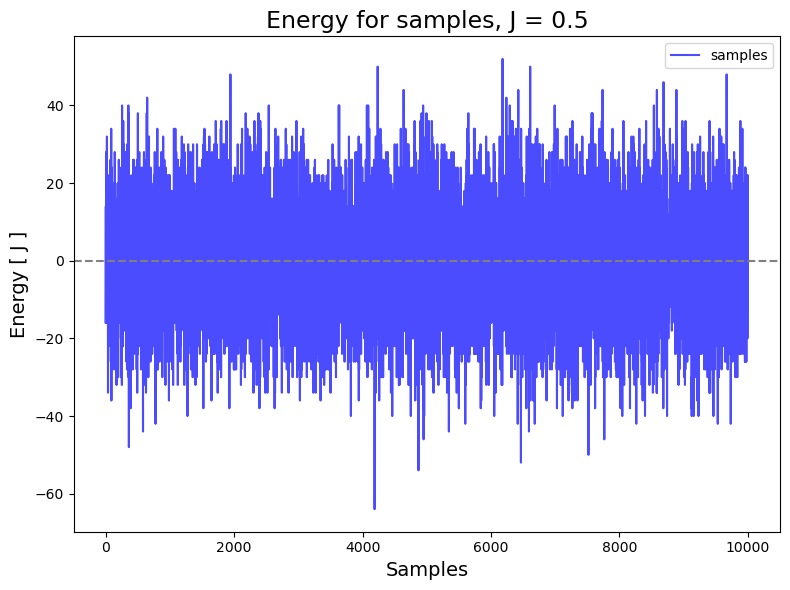

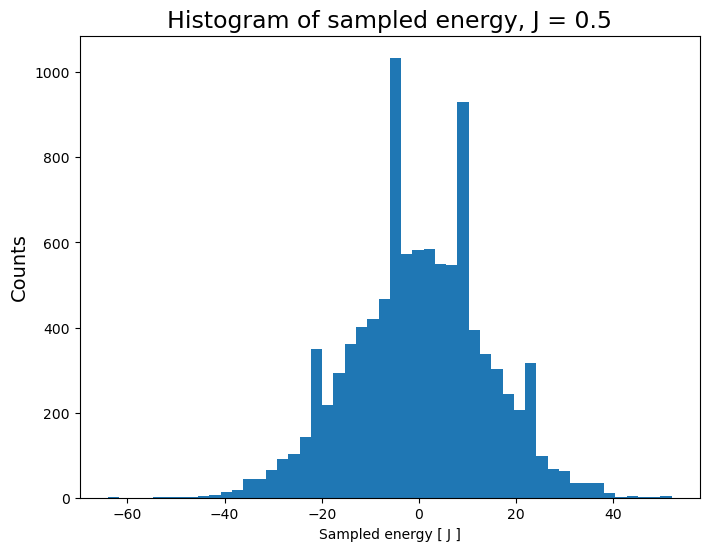

In [2]:
import numpy as np

class IsingModel:
    """
    A class to represent the Ising model with customizable parameters.
    
    Attributes:
    - size (int): The size of the lattice (NxN).
    - J (float): Coupling constant.
    - h (float): External magnetic field.
    - boundary_condition (str): The type of boundary condition ("helical" or other future options).
    - sampling_method (str): The method of sampling ("uniform" for now).
    """
    
    def __init__(self, size, J=1, h=0, boundary_condition="helical", sampling_method="uniform", seed=None):
        """
        Initialize the Ising model.
        
        Parameters:
        - size (int): Size of the lattice (NxN).
        - J (float): Coupling constant (default is 1).
        - h (float): External magnetic field (default is 0).
        - boundary_condition (str): Type of boundary condition (default is "helical").
        - sampling_method (str): Sampling method (default is "uniform").
        - seed (int, optional): Random seed for reproducibility.
        """
        self.size = size
        self.J = J
        self.h = h
        self.boundary_condition = boundary_condition
        self.sampling_method = sampling_method
        self.seed = seed
        
        if seed is not None:
            np.random.seed(seed)
    
    def _initialize_spins(self):
        """
        Initialize a random spin configuration.
        
        Returns:
        - spins (np.ndarray): 1D array of spins in {-1, 1}.
        """
        return np.random.choice([-1, 1], size=self.size**2)
    
    def _get_neighbors(self, i):
        """
        Get the neighbors of a spin at index i using helical boundary conditions.
        
        Parameters:
        - i (int): Index of the spin.
        
        Returns:
        - neighbors (list of int): Indices of neighboring spins.
        """
        N = self.size
        N2 = N**2
        neighbors = [
            (i + 1) % N + (i // N) * N,  # Right neighbor
            (i - 1 + N) % N + (i // N) * N,  # Left neighbor
            (i + N + N2) % N2,  # Below neighbor
            (i - N + N2) % N2,  # Above neighbor
        ]
        return neighbors
    
    def _calculate_energy(self, spins):
        """
        Calculate the energy of a spin configuration.
        
        Parameters:
        - spins (np.ndarray): 1D array of spins.
        
        Returns:
        - energy (float): Total energy of the configuration.
        """
        N = self.size
        energy = 0
        for i in range(N**2):
            neighbors = self._get_neighbors(i)
            energy -= self.J * spins[i] * sum(spins[j] for j in neighbors)  # Interaction term
            energy -= self.h * spins[i]  # Magnetic field term
        return energy / 2  # Divide by 2 to correct for double counting
    
    def sample_energies(self, num_samples):
        """
        Sample energies of random configurations.
        
        Parameters:
        - num_samples (int): Number of random configurations to sample.
        
        Returns:
        - energies (list of float): Energies of the sampled configurations.
        """
        if self.sampling_method != "uniform":
            raise NotImplementedError(f"Sampling method '{self.sampling_method}' is not implemented.")
        
        energies = []
        for _ in range(num_samples):
            spins = self._initialize_spins()
            energy = self._calculate_energy(spins)
            energies.append(energy)
        return energies

    def energy_normalized(self, energies):
        '''
        Convert array of energies to energy per bond: e = E/2N^2

        Parameters: 
        - array of energies

        Returns:
        - array with energy per bond
        '''
        return energies/(2*self.size**2)

    def visualize_energy(self, energies):
        '''
        Functionality to plot the variation of the sampled energies

        Parameters: 
        - energies: array containing all the different sampled energies

        returns: 
        - visualization of the energy fluctuations under random sampling
        '''
        fig, ax = plt.subplots(1,1, figsize=(8,6))
        samples = np.linspace(0, len(energies), len(energies))
        ax.set_xlabel('Samples', fontsize=14)
        ax.set_ylabel('Energy [ J ]', fontsize=14)
        title = 'Energy for samples, J = '+str(self.J)
        ax.plot(samples, energies, color='blue', alpha=0.7, label='samples')
        ax.legend()
        plt.axhline(0, color='gray', linestyle='dashed')
        ax.set_title(title, fontsize=17)
        plt.tight_layout()
        plt.show()

    def make_histogram(self, energies, bins=25, normalize=False):
        fig, ax = plt.subplots(1,1, figsize=(8,6))
        title= 'Histogram of sampled energy, J = '+str(self.J)
        ax.hist(energies, bins=bins)
        if normalize:
            return NotImplementedError
            ax.setylabel('Normalized counts', fontsize=14)
        ax.set_xlabel('Sampled energy [ J ]')
        ax.set_ylabel('Counts', fontsize=14)
        ax.set_title(title, fontsize=17)


# Example usage
if __name__ == "__main__":
    # Initialize the Ising model
    model = IsingModel(size=20, J=0.5, h=0, boundary_condition="helical", sampling_method="uniform", seed=42)
    
    # Sample energies
    num_samples = 10000
    energies = model.sample_energies(num_samples)
    
    print("Sampled Energies:")
    # print(energies)
    model.visualize_energy(energies)
    model.make_histogram(energies, bins=50)


This plot should look like white noise. Normally this should be the case, if the random sampling is done correctly. We can check this by plotting the histogram of the sampled energies, normalizing these and plotting against the gaussian distribution.

In [ ]:
def make_histogram(self, energies, bins=25, normalize=False):
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    title= 'Histogram of sampled energy, J = '+str(self.J)
    ax.hist(energies, bins=bins)
    if normalize:
        return NotImplementedError
    ax.set_xlabel('Sampled energy [ J ]')

In [ ]:
array1 = np.asarray([1,2,3])
array2 = np.asarray([4,5,6])
array3 = np.asarray([7,8,9])

array1 = np.vstack([array1, array2])
array1 = np.vstack([array1, array3])
print(array1)